## Loading labrary

In [1]:
import time
import matplotlib.pyplot as plt
import copy
import collections
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import scipy.sparse as sp
import time
import zipfile
import os
import itertools
import os.path as osp
from typing import Union, Tuple, Optional

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune
from torch import Tensor

os.environ["DGLBACKEND"] = "pytorch"
import dgl
import dgl.data
import torch
import torch.nn as nn
import torch.nn.functional as F

#from utils import *

### Loading dataset

The dataset is a set of graphs, each with node features and a single
label. One can see the node feature dimensionality and the number of
possible graph categories of ``GINDataset`` objects in ``dim_nfeats``
and ``gclasses`` attributes.




In [2]:
# Generate a synthetic dataset with 10000 graphs, ranging from 10 to 500 nodes.
dataset = dgl.data.GINDataset("PROTEINS", self_loop=True)

Defining Data Loader
--------------------

A graph classification dataset usually contains two types of elements: a
set of graphs, and their graph-level labels. Similar to an image
classification task, when the dataset is large enough, we need to train
with mini-batches. When you train a model for image classification or
language modeling, you will use a ``DataLoader`` to iterate over the
dataset. In DGL, you can use the ``GraphDataLoader``.

You can also use various dataset samplers provided in
`torch.utils.data.sampler <https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler>`__.
For example, this tutorial creates a training ``GraphDataLoader`` and
test ``GraphDataLoader``, using ``SubsetRandomSampler`` to tell PyTorch
to sample from only a subset of the dataset.




In [3]:
from dgl.dataloading import GraphDataLoader

In [4]:
from torch.utils.data.sampler import SubsetRandomSampler

num_examples = len(dataset)
num_train = int(num_examples * 0.8)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=5, drop_last=False
)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=5, drop_last=False
)

Define Model
------------

This tutorial will build a two-layer `Graph Convolutional Network
(GCN) <http://tkipf.github.io/graph-convolutional-networks/>`__. Each of
its layer computes new node representations by aggregating neighbor
information. If you have gone through the
:doc:`introduction <1_introduction>`, you will notice two
differences:

-  Since the task is to predict a single category for the *entire graph*
   instead of for every node, you will need to aggregate the
   representations of all the nodes and potentially the edges to form a
   graph-level representation. Such process is more commonly referred as
   a *readout*. A simple choice is to average the node features of a
   graph with ``dgl.mean_nodes()``.

-  The input graph to the model will be a batched graph yielded by the
   ``GraphDataLoader``. The readout functions provided by DGL can handle
   batched graphs so that they will return one representation for each
   minibatch element.




In [5]:
from dgl.nn import GraphConv


class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)
        self.conv3 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        h = F.relu(h)
        h = self.conv3(g, h)
        g.ndata["h"] = h
        return dgl.mean_nodes(g, "h")
    
    

Training 


In [6]:
# Create the model with given dimensions
model = GCN(dataset.dim_nfeats, 16, dataset.gclasses)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



epoch_losses = []
for epoch in range(100):
    epoch_loss = 0
    for iter, (batched_graph, labels) in enumerate(train_dataloader):
    #for batched_graph, labels in train_dataloader:
        pred = model(batched_graph, batched_graph.ndata["attr"].float())
        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    
    if epoch%10==0 :
      
        print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)



Epoch 0, loss 0.0047
Epoch 10, loss 0.0040
Epoch 20, loss 0.0036
Epoch 30, loss 0.0014
Epoch 40, loss 0.0025
Epoch 50, loss 0.0031
Epoch 60, loss 0.0043
Epoch 70, loss 0.0022
Epoch 80, loss 0.0032
Epoch 90, loss 0.0032


In [17]:
def accuracy(data):
    num_correct = 0
    num_tests = 0
    for batched_graph, labels in data:
        pred = model(batched_graph, batched_graph.ndata["attr"].float())
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
        return num_correct / num_tests

print("Train accuracy:", accuracy(train_dataloader))
print("Test accuracy:", accuracy(test_dataloader))

Train accuracy: 0.8
Test accuracy: 0.6


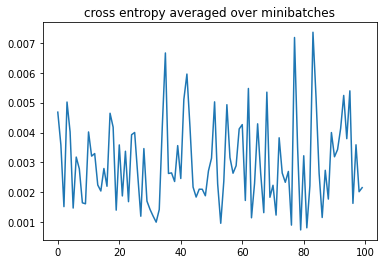

In [7]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()